# Mapping problem using moscot  
from dissociated scRNAseq data to spatial data 

### Import packages

In [1]:
!pip install decoupler

In [2]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [3]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [4]:
adata_sc = sc.read('../../../../spatial_pancreas_data/preprocessed_data/dissociated_nd_annotation_l0.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 21453 × 23146
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
     var: 'n_cells'
     uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
     obsm: 'X_pca', 'X_scVI', 'X_umap'
     layers: 'counts', 'soupX_counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK

In [ ]:
adata_sc.X.max()

In [ ]:
adata_sc.layers['counts'].max()

In [ ]:
adata_sc.layers['soupX_counts'].max()

In [ ]:
adata_s1.X.max()

In [ ]:
adata_s1.layers['counts'].max()

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [5]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['T1D'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 47251 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [6]:
adata_sp.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

In [7]:
cluster2annotation = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Delta' : 'Endocrine',
    'Ductal' : 'Ductal',
    'Ductal_Acinar_MUC1_AMY2A' : 'Ductal',
    'Immune' : 'Immune',
    'T-cells' : 'Immune',
    'Fibroblasts' : 'Fibroblasts',
    'Endothelial' : 'Endothelial',
    'Lymphatic' : 'Endothelial',
    'Acinar_OLFM4+' : 'Acinar', 
    'Acinar' : 'Acinar'
}

adata_sc.obs['cell_type'] = adata_sc.obs['cell_type_coarse'].map(cluster2annotation).astype('category')

adata_sc.obs['cell_type'].cat.reorder_categories(['Acinar','Alpha','Beta','Ductal','Endocrine','Endothelial',
                                                         'Fibroblasts','Immune'])#,inplace=True)

AAACCCAGTGGTCTCG-1         Acinar
AAACCCATCCATCCGT-1         Acinar
AAACGAATCGAAATCC-1         Acinar
AAACGAATCGCCTAGG-1         Acinar
AAACGCTAGGCTAACG-1         Acinar
                         ...     
TTTGTTGGTGAGTAGC-1         Acinar
TTTGTTGGTGTATACC-1         Acinar
TTTGTTGGTGTCCACG-1         Acinar
TTTGTTGTCAACTGGT-1    Fibroblasts
TTTGTTGTCGTTAGAC-1         Acinar
Name: cell_type, Length: 21453, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial', 'Fibroblasts', 'Immune']

In [8]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    layer='counts',
)
adata_sc

AnnData object with n_obs × n_vars = 21453 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

Pseudobulk dissociated data

In [9]:
import decoupler as dc

adatas_sc_pb = []
for ct in adata_sc.obs.cell_type.unique():
    cell_subset = adata_sc[adata_sc.obs['cell_type'] == ct]
    
    cell_subset.X = cell_subset.layers['counts'] #make sure to use raw data
    
    rep_adata = sc.AnnData(X = cell_subset.X.sum(axis = 0),
                           var = cell_subset.var[[]])
    
    rep_adata.obs_names = [ct]
    
    adatas_sc_pb.append(rep_adata)

adata_sc_pb = sc.concat(adatas_sc_pb)
adata_sc_pb

adata_sc_pb.obs['cell_type'] = pd.Categorical(['Acinar', 'Ductal', 'Fibroblasts', 'Beta', 'Alpha', 'Endocrine',
       'Immune', 'Endothelial'])

In [10]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_sc,
    sample_col='Sample',
    groups_col='cell_type',
    layer='soupX_counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 21 × 5000
    obs: 'Sample', 'doublet', 'outlier', 'mt_outlier', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'psbulk_props'

In [11]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [12]:
pdata.uns['cell_type_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

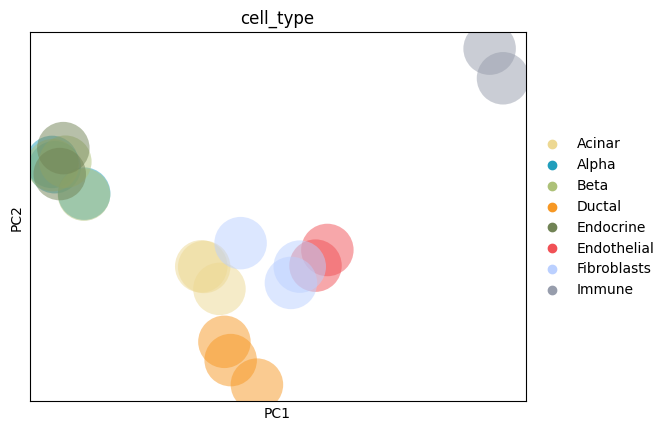

In [13]:
sc.pl.pca(pdata,color='cell_type', alpha=.5)

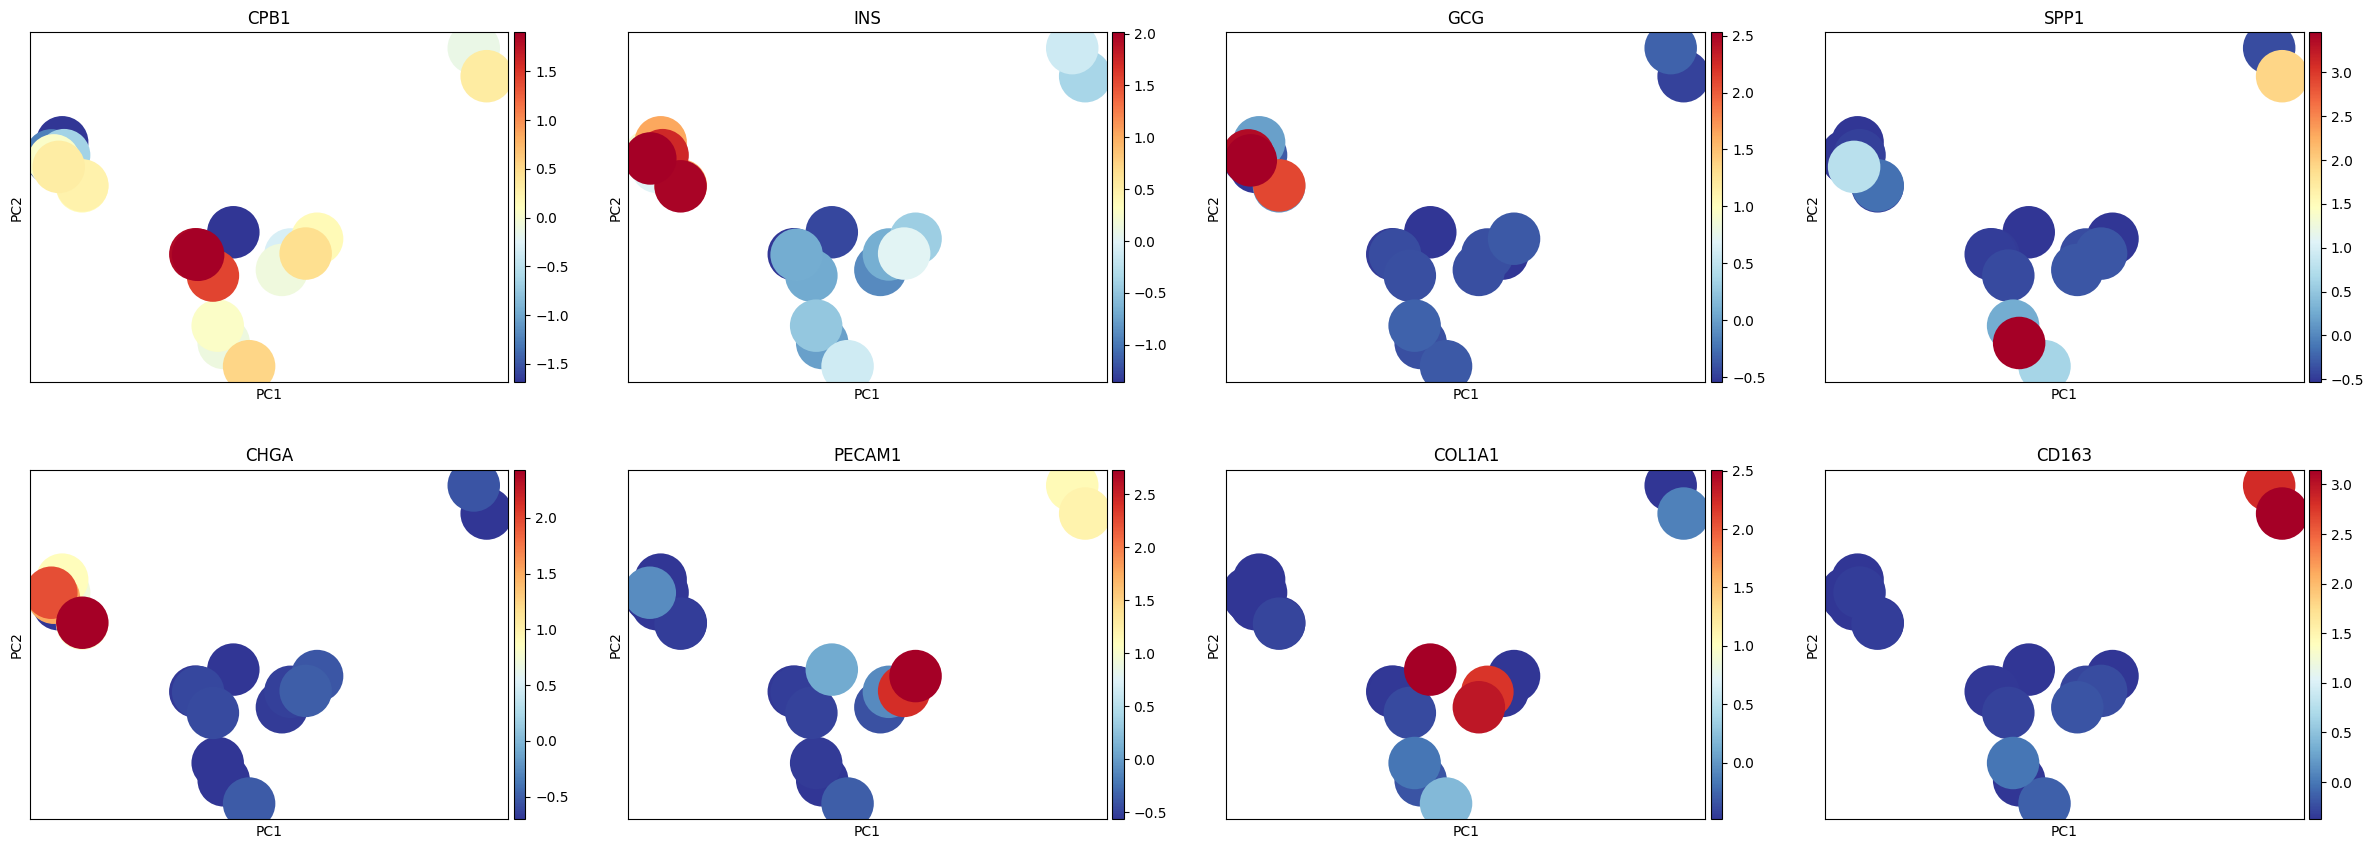

In [13]:
sc.pl.pca(pdata,color=['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'],
          ncols=4,cmap='RdYlBu_r')

Subset to a field of view to test the mapping problem 

In [14]:
adata_sp_fov_2 = adata_sp[np.isin(adata_sp.obs['fov'],['2'])].copy()
adata_sp_fov_2

AnnData object with n_obs × n_vars = 4450 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

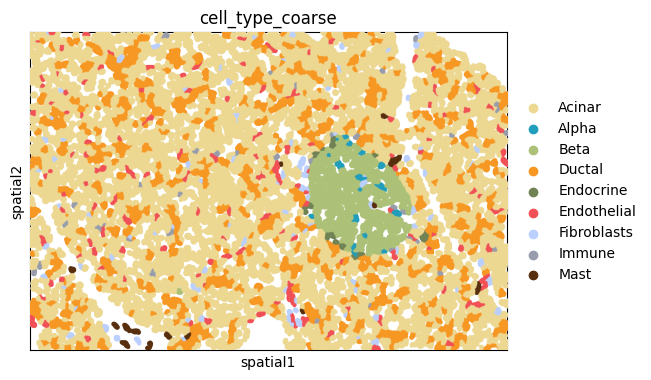

In [15]:
sq.pl.spatial_segment(adata_sp_fov_2,color='cell_type_coarse',
                      library_key='fov', seg_cell_id='cell_ID',img=False)

In [16]:
sc.pp.pca(adata_sp_fov_2)
sc.pp.neighbors(adata_sp_fov_2)
sc.tl.umap(adata_sp_fov_2)

Normalization to avoid technical artifacts (has to be per fov)

In [17]:
spatial = adata_sp_fov_2.obsm['spatial']
adata_sp_fov_2.obsm['spatial_norm'] = spatial - spatial.mean() / spatial.std()
adata_sp_fov_2.obsm['PCA_spatial'] = np.concatenate([adata_sp_fov_2.obsm['spatial_norm'], adata_sp_fov_2.obsm['X_pca']], axis = 1)

### Preprare and solve the mapping problem parameter tunning

In [18]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [19]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [20]:
# Leave the control genes out of the fitting
adata_sp_fov_2_mp = adata_sp_fov_2[:,~adata_sp_fov_2.var_names.isin(markers2impute)].copy()

In [21]:
params = {
    'epsilon': [0.001,0.01,0.05,0.1],#[0.05, 0.1], #0.01 default 
    'alpha': [0.2,0.3,0.4,0.5],#[0.2,0.3], #0.5 default
    'tau_a': [1, 0.999, 0.995, 0.990, 0.900],#[1, 0.999, 0.995, 0.990, 0.900], #0.990 default
    'tau_b': [1, 0.999, 0.995, 0.990, 0.900]#[1, 0.999, 0.995, 0.990, 0.900] #0.990 default
}

In [22]:
pdata

AnnData object with n_obs × n_vars = 21 × 5000
    obs: 'Sample', 'doublet', 'outlier', 'mt_outlier', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [23]:
from sklearn.metrics import f1_score

In [24]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=pdata, adata_sp=adata_sp_fov_2_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_sp_fov_2.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'PCA_spatial'},
                    cost = 'cosine',#'cosine', #'sq_euclidean', 
                    joint_attr = {'attr':'X'} #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through imputation
                adata_imputed = mp.impute(var_names=genes2impute)
                correlations_hallmark_genes = []

                for i in markers2impute:
                    gene = i
                    obs_genes = adata_sp_fov_2[:,[gene]].X.copy().toarray().flatten()
                    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                    correlation, p_value = pearsonr(obs_genes, imp_genes)
                    row_data = {
                        'gene' : gene,
                        'Pearson_correlation' : correlation,
                        'P_value' : p_value
                    }
                    correlations_hallmark_genes.append(row_data)
                
                df = pd.DataFrame(correlations_hallmark_genes)

                #evaluating the mapping problem through annotation mapping 
                anno_map_max = mp.annotation_mapping("max","cell_type",source="src",forward=False,batch_size=256)
                adata_sp_fov_2_mp.obs["cell_type_max"] = anno_map_max["cell_type"].values
                adata_sp_fov_2_mp.obs["cell_type_max"] = adata_sp_fov_2_mp.obs["cell_type_max"].astype("category")

                pred_ann = adata_sp_fov_2_mp.obs["cell_type_max"].cat.categories.unique()
                adata_sp_fov_2_cmp = adata_sp_fov_2_mp[adata_sp_fov_2_mp.obs.cell_type_coarse.isin(pred_ann),:].copy()

                y_true = np.array(adata_sp_fov_2_cmp.obs["cell_type_coarse"])
                y_pred = np.array(adata_sp_fov_2_cmp.obs["cell_type_max"])
                
                f1 = f1_score(y_true, y_pred, average = 'weighted')

                # weigth contribution of imputation task and cell type mapping task 
                score = 1/2*df['Pearson_correlation'].mean() + 1/2*f1

                
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'cpb1_corr' : df.loc[df['gene'] == 'CPB1', 'Pearson_correlation'].values[0],
                    'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                    'gcg_corr' : df.loc[df['gene'] == 'GCG', 'Pearson_correlation'].values[0],
                    'spp1_corr' : df.loc[df['gene'] == 'SPP1', 'Pearson_correlation'].values[0],
                    'chga_corr' : df.loc[df['gene'] == 'CHGA', 'Pearson_correlation'].values[0],
                    'pecam1_corr' : df.loc[df['gene'] == 'PECAM1', 'Pearson_correlation'].values[0],
                    'col1a1_corr' : df.loc[df['gene'] == 'COL1A1', 'Pearson_correlation'].values[0],
                    'cd163_corr' : df.loc[df['gene'] == 'CD163', 'Pearson_correlation'].values[0],
                    'mean_corr' : df['Pearson_correlation'].mean(),
                    'ct_true' : y_true,
                    'ct_pred' : y_pred,
                    'F1 score' : f1,
                    'score' : score
                }
                evaluation.append(row_data)
                del mp
                del adata_imputed
df = pd.DataFrame(evaluation)
df

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            


2024-07-03 15:52:14.927677: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)]. 

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                        

/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            
WARNING  Solver did not converge                                                                                   


/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_3093057/604473097.py:28: ConstantIn

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            


tau_a  tau_b  alpha  epsilon  cpb1_corr  ins_corr  gcg_corr  spp1_corr  \
0      1.0    1.0    0.2    0.001   0.270658  0.272762  0.335363   0.185557   
1      1.0    1.0    0.2    0.010   0.283735  0.284088  0.352365   0.197980   
2      1.0    1.0    0.2    0.050   0.341226  0.342471  0.441665   0.249515   
3      1.0    1.0    0.2    0.100   0.402924  0.403743  0.488379   0.284366   
4      1.0    1.0    0.3    0.001   0.300521  0.273936  0.348901   0.152338   
..     ...    ...    ...      ...        ...       ...       ...        ...   
395    0.9    0.9    0.4    0.100   0.533166  0.485618  0.553407   0.242509   
396    0.9    0.9    0.5    0.001        NaN       NaN       NaN        NaN   
397    0.9    0.9    0.5    0.010        NaN       NaN       NaN        NaN   
398    0.9    0.9    0.5    0.050        NaN       NaN       NaN        NaN   
399    0.9    0.9    0.5    0.100   0.454420  0.362061  0.392552   0.205985   

     chga_corr  pecam1_corr  col1a1_corr  cd163_corr  mean_corr  \
0     0.338442     0.143925     0.140664    0.085280   0.221582   
1     0.348714     0.147917     0.144191    0.084492   0.230435   
2     0.393228     0.162159     0.180401    0.104735   0.276925   
3     0.426513     0.182193     0.213336    0.158588   0.320005   
4     0.339088     0.092015     0.115244    0.045106   0.208394   
..         ...          ...          ...         ...        ...   
395   0.506244     0.150184     0.238005    0.159062   0.358524   
396        NaN          NaN          NaN         NaN        NaN   
397        NaN          NaN          NaN         NaN        NaN   
398        NaN          NaN          NaN         NaN        NaN   
399   0.360480     0.067838     0.138168    0.084783   0.258286   

                                               ct_true  \
0    [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...   
1    [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...   
2    [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...   
3    [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...   
4    [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...   
..                                                 ...   
395  [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...   
396  [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...   
397  [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...   
398  [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...   
399  [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...   

                                               ct_pred  F1 score     score  
0    [Endothelial, Ductal, Fibroblasts, Acinar, Duc...  0.417432  0.319507  
1    [Endothelial, Ductal, Fibroblasts, Acinar, Duc...  0.418396  0.324416  
2    [Endothelial, Ductal, Fibroblasts, Acinar, Duc...  0.441111  0.359018  
3    [Endothelial, Ductal, Fibroblasts, Acinar, Duc...  0.476784  0.398395  
4    [Endothelial, Ductal, Fibroblasts, Acinar, Duc...  0.396768  0.302581  
..                                                 ...       ...       ...  
395  [Endothelial, Ductal, Fibroblasts, Acinar, Duc...  0.558163  0.458344  
396  [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...  1.000000       NaN  
397  [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...  1.000000       NaN  
398  [Acinar, Acinar, Acinar, Acinar, Acinar, Acina...  1.000000       NaN  
399  [Endothelial, Fibroblasts, Fibroblasts, Acinar...  0.501897  0.380091  

[400 rows x 17 columns]

In [ ]:
df.to_csv('pseudobulk_cosine_joint_attr_X_imp.csv', sep='\t', index=False)

In [26]:
# Find the index label corresponding to the maximum value in a specific column
max_index = df['ins_corr'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values = df.loc[max_index]

# Print the values
print(max_row_values)

tau_a                                                       0.99
tau_b                                                        0.9
alpha                                                        0.2
epsilon                                                      0.1
cpb1_corr                                               0.573944
ins_corr                                                0.618381
gcg_corr                                                0.708863
spp1_corr                                               0.195523
chga_corr                                               0.713944
pecam1_corr                                             0.205748
col1a1_corr                                             0.216831
cd163_corr                                              0.160906
mean_corr                                               0.424268
ct_true        [Acinar, Ductal, Acinar, Acinar, Ductal, Acina...
ct_pred        [Endothelial, Ductal, Fibroblasts, Acinar, Duc...
F1 score                 

### Analysis of the transport plan with the best set of found parameters

In [27]:
best_param = max_row_values.to_dict()
best_param

{'tau_a': 0.99,
 'tau_b': 0.9,
 'alpha': 0.2,
 'epsilon': 0.1,
 'cpb1_corr': 0.5739441471043363,
 'ins_corr': 0.6183810414884112,
 'gcg_corr': 0.7088628396126104,
 'spp1_corr': 0.19552337792402621,
 'chga_corr': 0.7139440532838401,
 'pecam1_corr': 0.20574838415420088,
 'col1a1_corr': 0.21683090691351234,
 'cd163_corr': 0.1609058813617524,
 'mean_corr': 0.4242675789803363,
 'ct_true': array(['Acinar', 'Ductal', 'Acinar', ..., 'Acinar', 'Acinar', 'Acinar'],
       dtype=object),
 'ct_pred': array(['Endothelial', 'Ductal', 'Fibroblasts', ..., 'Endocrine', 'Beta',
        'Beta'], dtype=object),
 'F1 score': 0.680218828010519,
 'score': 0.5522432034954277}

In [29]:
mp = MappingProblem(adata_sc=pdata, adata_sp=adata_sp_fov_2_mp)
mp = mp.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_sp_fov_2.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'PCA_spatial'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'])

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4450, 21)].                                            


#### Imputation

In [30]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed = mp.impute(var_names=pdata.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed.append(adata_imputed)
    del adata_imputed

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 8.063347339630127 seconds


In [31]:
import anndata as ad
adata_imputed  = ad.concat(adatas_imputed, join='outer',uns_merge='same',axis=1)
adata_imputed

AnnData object with n_obs × n_vars = 4450 × 5000

In [32]:
adata_sp_fov_2

AnnData object with n_obs × n_vars = 4450 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'spatial_norm', 'PCA_spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'd

In [33]:
adata_imputed.uns['spatial'] = adata_sp_fov_2.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_2.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_2.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_2.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 4450 × 5000
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

Plotting imputed gene expression

In [34]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

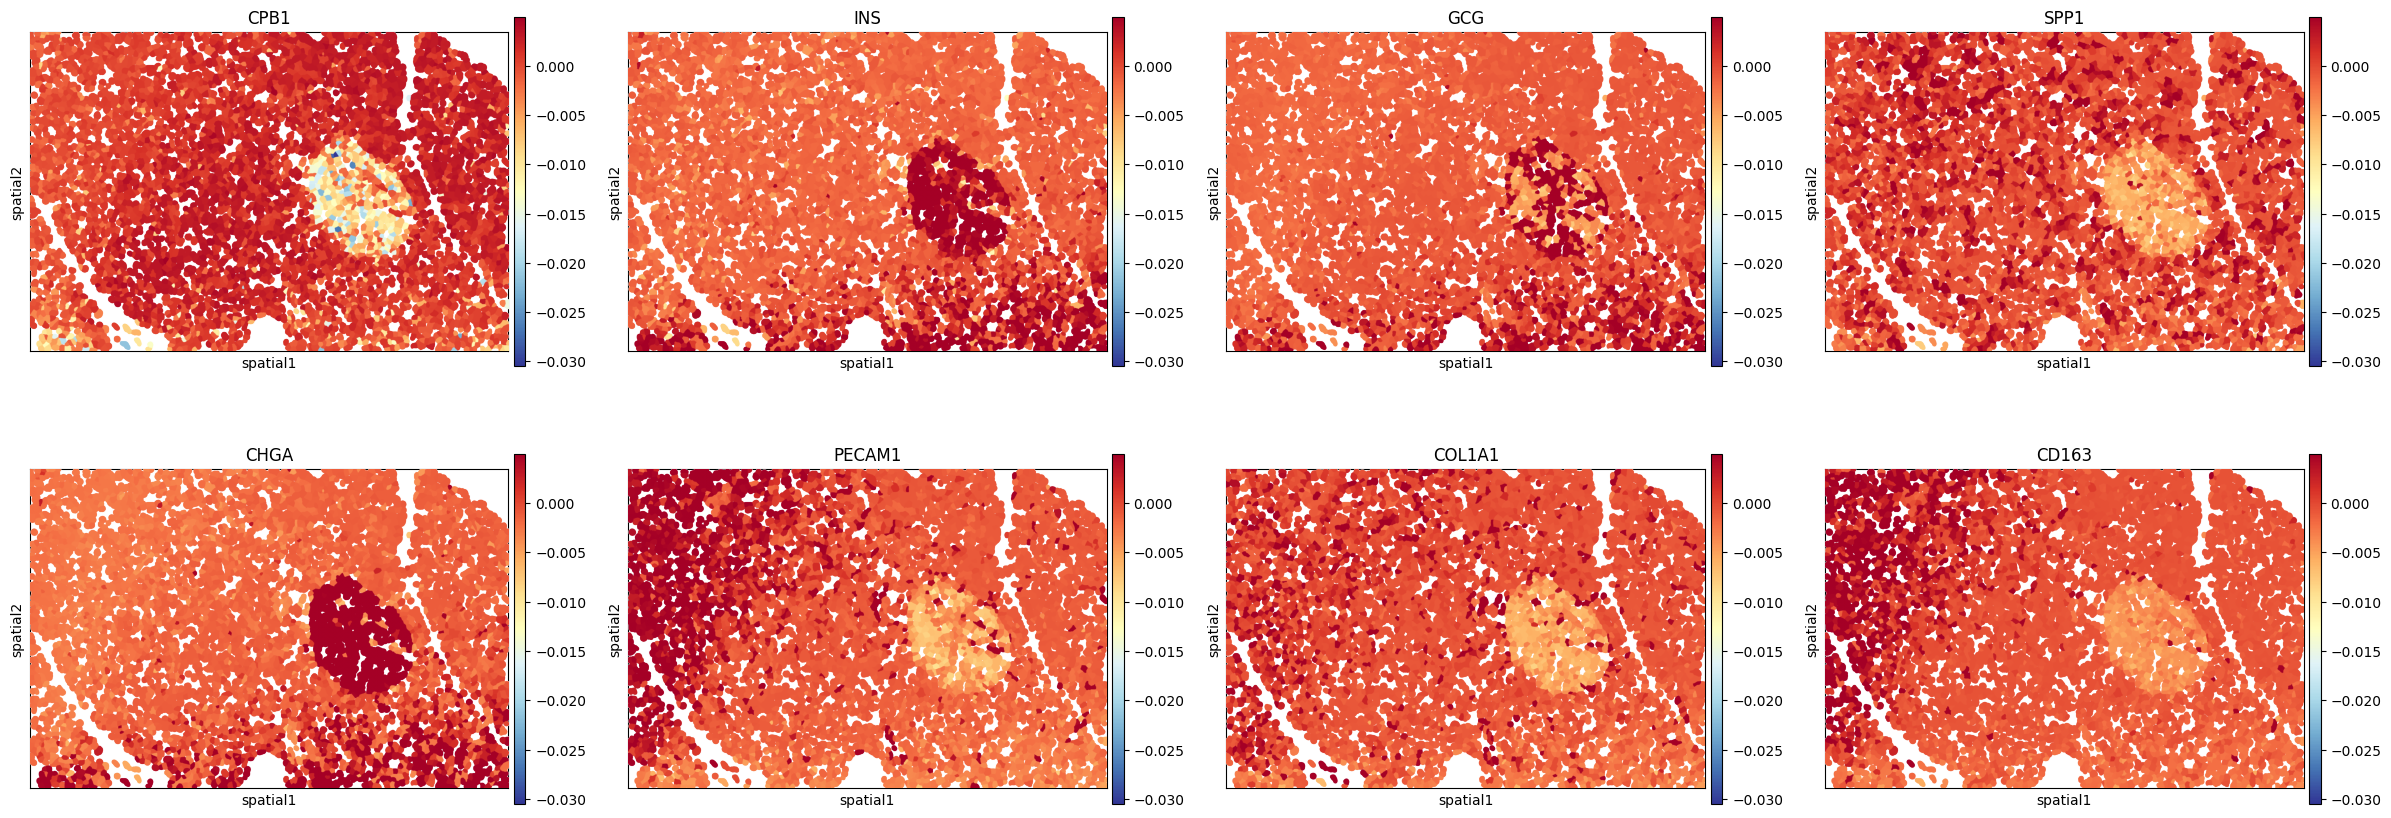

In [35]:
sq.pl.spatial_segment(adata_imputed,color=markers2impute,ncols=4,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Plotting observed gene expression for hallmark hormone genes

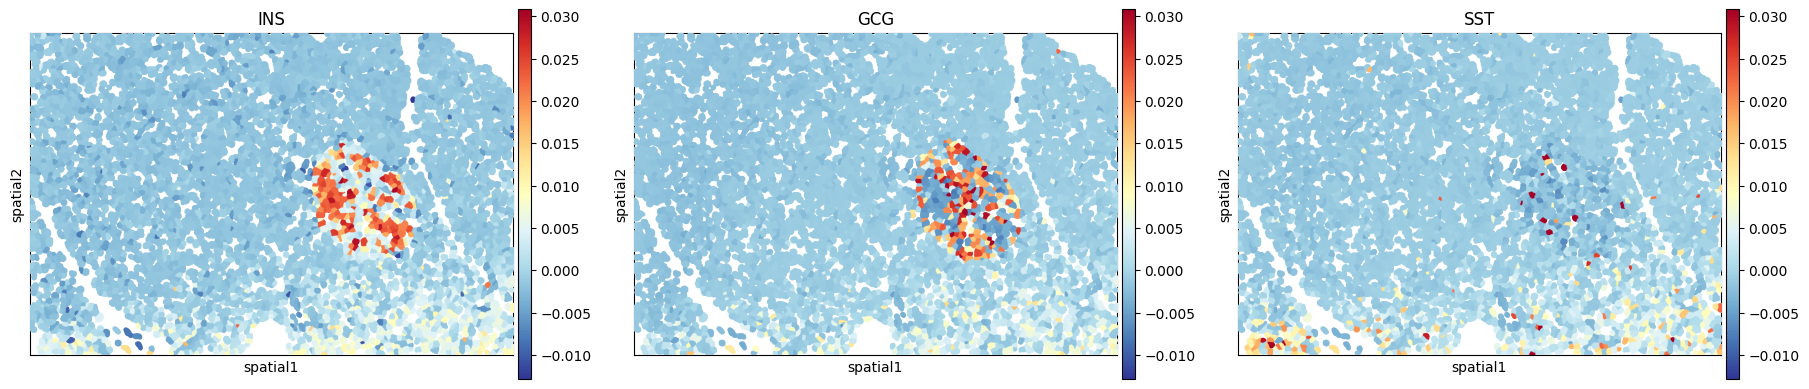

In [36]:
sq.pl.spatial_segment(adata_imputed,color=['INS','GCG','SST'],ncols=4,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=['CPB1'],ncols=4,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [37]:
adata_sp_fov_2, adata_imputed

(AnnData object with n_obs × n_vars = 4450 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'spatial_norm', 'PCA_spatial'
     varm: 'PCs'
     layers: 'counts'
     

In [38]:
adata_imputed.obs['cell_type_coarse'] = adata_sp_fov_2.obs['cell_type_coarse']

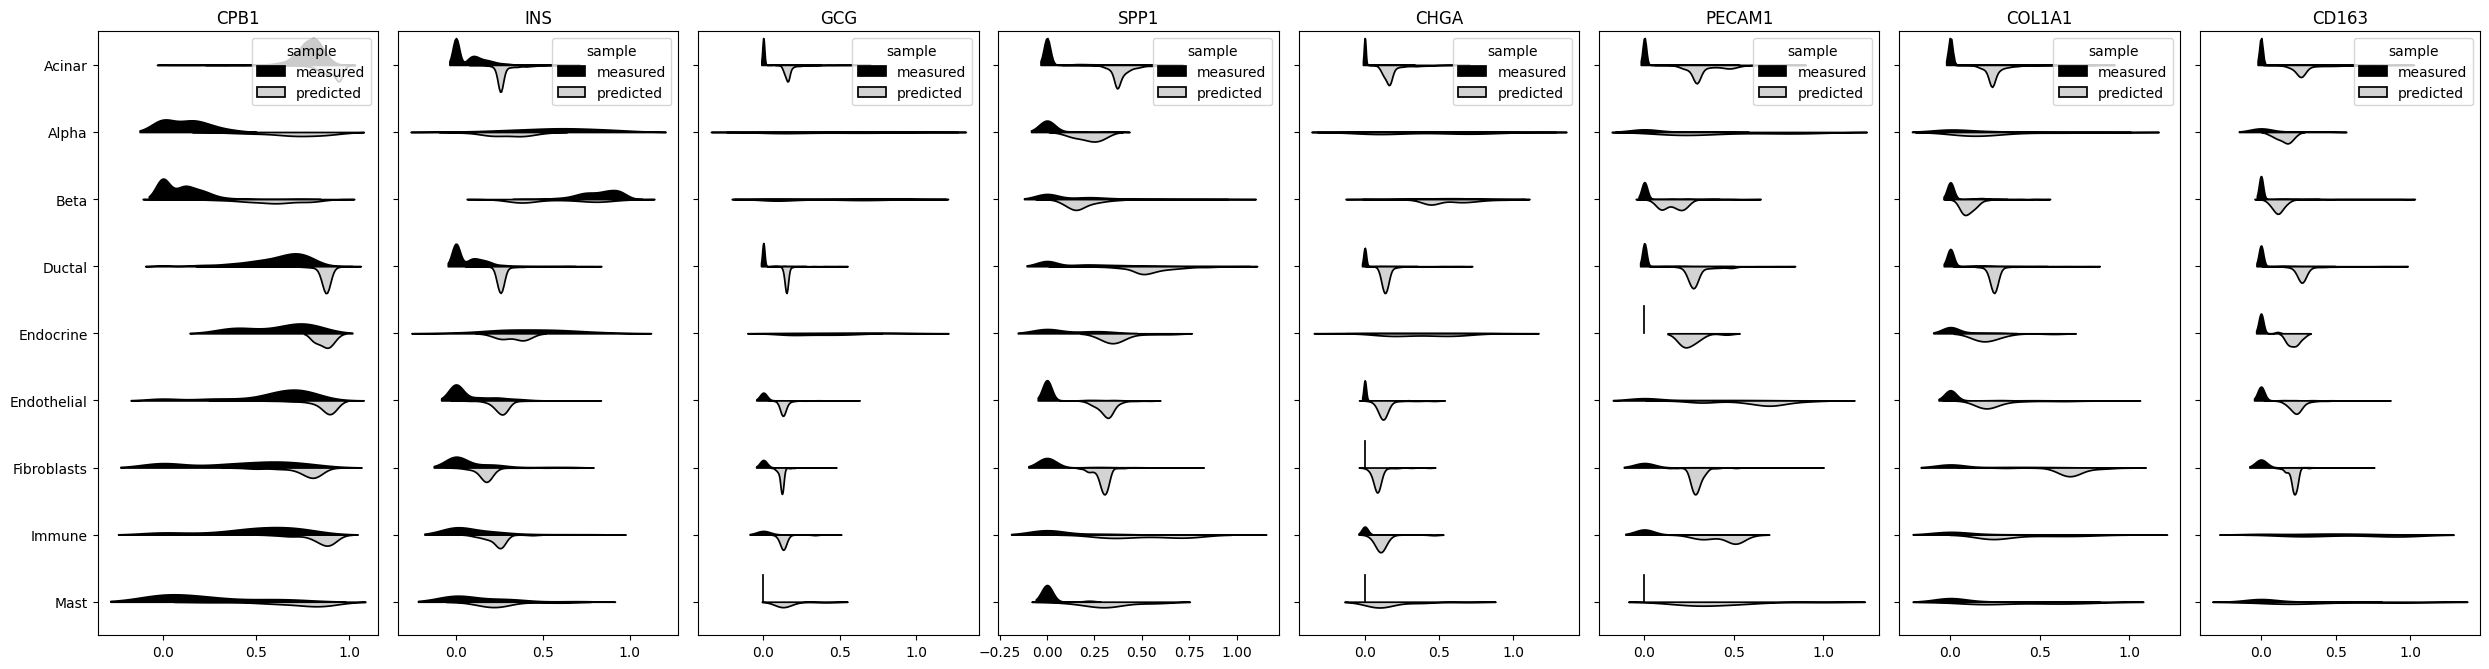

In [39]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1, len(markers2impute), figsize=(25, 6.8), sharey=True)

for i, marker in enumerate(markers2impute):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_2, [marker, "cell_type_coarse"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type_coarse"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type_coarse",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
        inner=None,
        palette={"measured": "black", "predicted": "lightgray"}
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
plt.tight_layout()
plt.show()

#### Annotation mapping

In [40]:
mp[("src", "tgt")]

OTProblem[stage='solved', shape=(4450, 21)]

In [41]:
type(pdata.obs.cell_type)

pandas.core.series.Series

In [42]:
pdata.obs.cell_type = pdata.obs.cell_type.astype("category")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [ ]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=1.0
%env XLA_PYTHON_CLIENT_ALLOCATOR=cub

Annotation mapping using “max” mode

In [43]:
start_time = time.time()

anno_map_max = mp.annotation_mapping(
    "max",
    "cell_type",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 0.6433103084564209 seconds


In [45]:
adata_sp_fov_2.obs["cell_type_max"] = anno_map_max["cell_type"].values
adata_sp_fov_2.obs["cell_type_max"] = adata_sp_fov_2.obs["cell_type_max"].astype("category")

In [46]:
adata_sp_fov_2.uns['cell_type_max_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

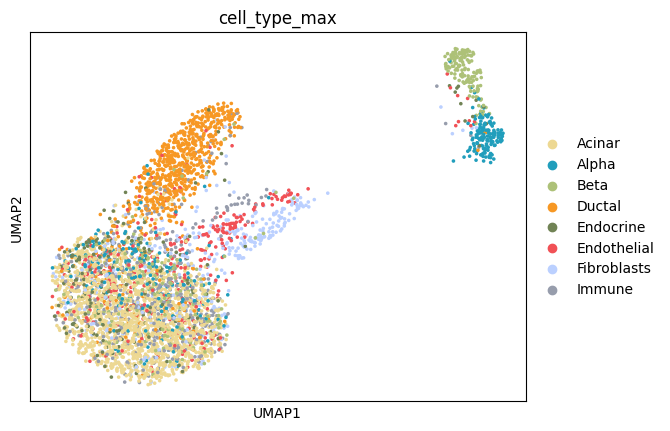

In [47]:
#sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_sp_fov_2, color=["cell_type_max"])

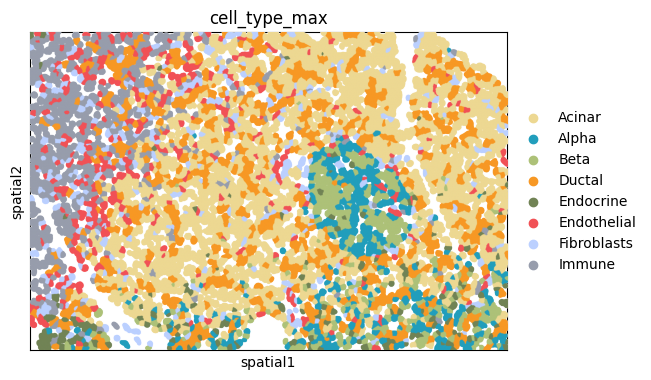

In [48]:
sq.pl.spatial_segment(adata_sp_fov_2,color='cell_type_max',size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Annotation mapping using the “sum” mode

In [49]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "cell_type",
    source="src",
    forward=False,
    batch_size=256,
)
adata_sp_fov_2.obs["cell_type_sum"] = anno_map_sum["cell_type"].values
adata_sp_fov_2.obs["cell_type_sum"] = adata_sp_fov_2.obs["cell_type_sum"].astype("category")

In [50]:
adata_sp_fov_2.uns['cell_type_sum_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

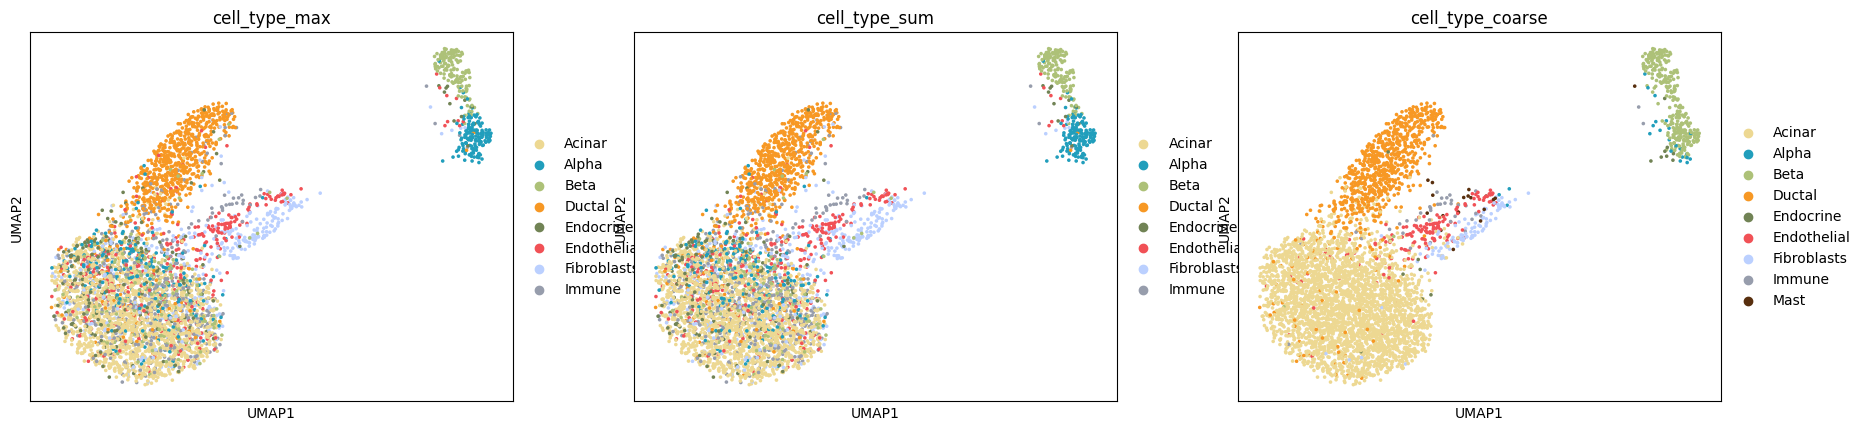

In [51]:
sc.pl.umap(adata_sp_fov_2, color=["cell_type_max", "cell_type_sum","cell_type_coarse"])

In [52]:
adata_sp_fov_2[adata_sp_fov_2.obs["cell_type_max"] == adata_sp_fov_2.obs["cell_type_sum"]].shape[
    0
] / adata_sp_fov_2.shape[0]

0.9402247191011236

In [53]:
adata_sp_fov_2_cmp = adata_sp_fov_2[~adata_sp_fov_2.obs.cell_type_coarse.isin(['Mast']),:].copy()
adata_sp_fov_2_cmp

AnnData object with n_obs × n_vars = 4432 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type_max', 'cell_type_sum'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap', 'cell_type_max_colors', 'cell_type_sum_colors'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap

In [54]:
adata_sp_fov_2_cmp[adata_sp_fov_2_cmp.obs["cell_type_max"] == adata_sp_fov_2_cmp.obs["cell_type_coarse"]].shape[
    0
] / adata_sp_fov_2_cmp.shape[0]

0.6008574007220217

In [55]:
adata_sp_fov_2_cmp[adata_sp_fov_2_cmp.obs["cell_type_sum"] == adata_sp_fov_2_cmp.obs["cell_type_coarse"]].shape[
    0
] / adata_sp_fov_2_cmp.shape[0]

0.6229693140794224

In [56]:
from sklearn.metrics import f1_score

In [57]:
y_true = np.array(adata_sp_fov_2_cmp.obs["cell_type_coarse"])
y_pred = np.array(adata_sp_fov_2_cmp.obs["cell_type_sum"])

f1 = f1_score(y_true, y_pred, average = 'weighted')

print("F1 score:", f1)

F1 score: 0.7025572891403531
